In [80]:
# setup of API keys
from dotenv import load_dotenv
load_dotenv()
import os 
os.environ['TAVILY_API_KEY'] = os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY'] = os.getenv("GROQ_API_KEY")


In [81]:
from langchain.document_loaders import PyPDFLoader

doc = PyPDFLoader('S:\AI_AGENTS\Python_N_Env\LangGraph\Projects\sample-job-description.pdf')
docs = doc.load()


<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
C:\Users\User\AppData\Local\Temp\ipykernel_24404\3948672777.py:3: SyntaxWarning: invalid escape sequence '\A'
  doc = PyPDFLoader('S:\AI_AGENTS\Python_N_Env\LangGraph\Projects\sample-job-description.pdf')


In [82]:
from langchain.document_loaders import PyPDFLoader

doc = PyPDFLoader('S:\AI_AGENTS\Python_N_Env\LangGraph\Projects\human-resources-resume-example.pdf')
docs1 = doc.load()


<>:3: SyntaxWarning: invalid escape sequence '\A'
<>:3: SyntaxWarning: invalid escape sequence '\A'
C:\Users\User\AppData\Local\Temp\ipykernel_24404\1090519743.py:3: SyntaxWarning: invalid escape sequence '\A'
  doc = PyPDFLoader('S:\AI_AGENTS\Python_N_Env\LangGraph\Projects\human-resources-resume-example.pdf')


In [128]:
jobDescripition = docs[0].page_content
applicant = docs1[0].page_content


In [84]:
from langchain_groq import ChatGroq
model = ChatGroq(model = 'llama-3.3-70b-versatile')

# **`Defining Job Requirement Node`**

In [109]:
from pydantic import BaseModel , Field
from langchain_core.prompts import ChatPromptTemplate
class JDrequirements(BaseModel):
    """Answer the requirements in the form of Bulletpoints """
    requirements : str = Field(description="Answer all the requirements in the form of Bulletpoints")

llm_with_str = model.with_structured_output(JDrequirements)
system = """You are an expert job requirement gathering assistant which gathers all the requirements and skills that are essential for the given job description . Atleast Give 5 Requirements"""

prompt = ChatPromptTemplate(
    [
        ('system' , system),
        ('human' , "Give all the requirement for the job description given below \n\n {description}")
    ]
)

JD_chain = prompt | llm_with_str

requirements = JD_chain.invoke({"description" : jobDescripition})


In [111]:
requirements = requirements.requirements

# **`Compatibility Score`**

In [ ]:
rand_str= 'according to the compatability between resume and job description'
class ComScore(BaseModel):
    """Measure the compatability"""
    score : str = Field(description="Score the compatability result between 0 to 100")
    requisite : str = Field(description="Requirements which are met or not")

llm_with_com = model.with_structured_output(ComScore)
system = "You are an expert Analyzer which analyze the compatibility between the requirements given by the job description and the resume of applicant and score the compatibility between 0 - 100 . score high if there is high compatibilty between requirements and resume of applicant"

prompt = ChatPromptTemplate(
    [
        ('system' , system),
        ('human' , "Requirements of job are {requirements} and resume of applicant is {resume}")
    ]
)

comp_chain = prompt | llm_with_com
score = comp_chain.invoke({"requirements" : requirements , "resume" : applicant} )


In [91]:
actual_score = score.score
actual_score

'90'

# **`Recommendation Node`**

In [101]:
class Recommender(BaseModel):
    """Give recommendation based on description"""
    recommendations : str = Field(description="Recommendations to enhance the compatability score")

llm_with_rec = model.with_structured_output(Recommender)
system = """You are an expert recommendation consultant with 20 years of experience. You are given with compatibility score of job requirements and resume of applicant. Based on your experience and considering job-requirements , give recommendations to applicant to enhance its resume and make it compatible with job description and increase its compatibility score. Give recommendations in Bullet format
Return a JSON object with a single field `recommendations`, which contains a string.
The string must contain exactly 5 recommendations, each on a new line starting with '*'.
Do not return a list or any other format."""

prompt = ChatPromptTemplate([
    ('system' , system),
    ('human' , "Job description is : {description} Resume of Applicant is : {resume} and the compatibility score between them is : {score}")
])

recom_chain = prompt | llm_with_rec
res = recom_chain.invoke({"description" : jobDescripition , "resume" : applicant , "score" : actual_score})

In [104]:
recommendation = res.recommendations

# **`Synthesizer`**

In [112]:
class Synthesizer(BaseModel):
    """Gather the information in unified Format"""
    requirements : str = Field(description="Requirements of Job Description")
    score : str = Field(description="Score of Compatibility of job description and resume of Applicant")
    recommendation : str = Field(description="Recommendation for improvement of resume")

llm_with_synth = model.with_structured_output(Synthesizer)

system = """You are an expert Synthesizer which gather the information in following format with Title of each Paragraph \n Requirements \n Score of Compatibility \n Recommendation """

prompt = ChatPromptTemplate([
    ('system' , system),
    ('human' , "Requirements  : {requirements} , Score : {score}  , Recommendation : {recommendation}")
])

synthersizer_chain = prompt | llm_with_synth

result = synthersizer_chain.invoke({"requirements" : requirements , "score" : actual_score , "recommendation" : recommendation})

In [ ]:
result.recommendation

Synthesizer(requirements='• Proficient with Microsoft Word and Excel\n• General knowledge of employment law and practices\n• Able to maintain a high level of confidentiality\n• Effective oral and written management communication skills\n• Experience with Human Resources Information system (HRIS) database management and record keeping', score='90', recommendation='* Improve knowledge of HR Information Systems and HRIS database management to enhance compatibility with the job description\n* Develop skills in employee safety, welfare, wellness, and health reporting to increase the compatibility score\n* Enhance experience in company-wide committee facilitation and participation to better align with the job requirements\n* Improve understanding of HR law and compliance with governmental regulations to increase compatibility with the job description\n* Consider obtaining certifications or training in areas such as employment law and strategic planning to further enhance the resume and incre

# **`Definition of State of Graph`**

In [130]:
from typing_extensions import TypedDict
class State(TypedDict):
    """State of Nodes of Graph"""
    job_desc : str
    resume : str
    requirements : str
    score : str
    recommendation : str
    finalized : str

# **`Definition of Nodes of Graph`**

In [131]:
def Job_req(state : State):
    """State the requirements mention in the job Description
    Args:
        state (dict) : the current state of Graph

    Returns:
        state (dict) : Updated state of Graph
    """
    job_desc = state['job_desc']
    result = JD_chain.invoke({"description" : job_desc})
    return {"requirements" : result}

def compatability_Score(state : State):
    """
    Determine the compatibility score of Job Requirements and Resume of Applicant
    Args:
        state (dict) : the current state of Graph

    Returns:
        state (dict) : Updated state of Graph
    """
    requirements = state["requirements"]
    resume = state['resume']
    result = comp_chain.invoke({"requirements" : requirements , "resume" : resume})
    return {'score' : result}

def recom_node(state : State):
    """
    Give the recommendations based on the job requirements and applicant resume
    Args:
        state (dict) : the current state of Graph

    Returns:
        state (dict) : Updated state of Graph
    
    """
    resume = state['resume']
    description = state["job_desc"]
    score = state['score']
    result = recom_chain.invoke({"description" : description , "resume" : resume , "score" : score})
    return {"recommendation" : result}

def synthesizer(state : State):
    """
    Synthesize the document in proper format in the form of Markdown
    Args:
        state (dict) : the current state of Graph

    Returns:
        state (dict) : Updated state of Graph
    """
    requirements = state["requirements"]
    recommendation = state["recommendation"]
    score = state['score']   
    result = synthersizer_chain.invoke({"requirements" : requirements , "score" : score , "recommendation" : recommendation})
    return {"finalized" : result}

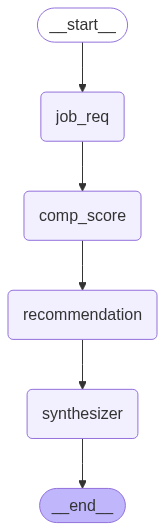

In [132]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(State)

## Defining the Nodes of Graph

builder.add_node('job_req' , Job_req)
builder.add_node('comp_score' , compatability_Score)
builder.add_node('recommendation' , recom_node)
builder.add_node('synthesizer' , synthesizer)

### Defining the Workflow

builder.add_edge(START , 'job_req')
builder.add_edge('job_req' , 'comp_score')
builder.add_edge('comp_score' , 'recommendation')
builder.add_edge('recommendation' , 'synthesizer')
builder.add_edge("synthesizer" , END)

graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [153]:
result = graph.invoke({"job_desc" : "Machine Learning Engineer", "resume" : applicant})

In [154]:
from IPython.display import display, Markdown

display(Markdown("### ✅ Requirements"))
display(Markdown(result['finalized'].requirements))

display(Markdown("### 📊 Score"))
display(Markdown(result['finalized'].score))

display(Markdown("### 💡 Recommendation"))
display(Markdown(result['finalized'].recommendation))


### ✅ Requirements

• Master’s or Ph.D. in Computer Science, Machine Learning, or related field
• 5+ years of experience in machine learning or a related field
• Strong understanding of machine learning algorithms and data structures
• Experience with deep learning frameworks such as TensorFlow or PyTorch
• Strong programming skills in languages such as Python, Java, or C++
• Experience with data preprocessing, feature engineering, and model evaluation
• Strong understanding of statistical modeling and data analysis
• Experience with cloud-based technologies such as AWS or Azure
• Strong communication and collaboration skills
• Experience with version control systems such as Git

### 📊 Score

0

### 💡 Recommendation

* Pursue a Master’s or Ph.D. in Computer Science, Machine Learning, or a related field to enhance your knowledge and skills in machine learning algorithms and data structures
* Acquire experience in machine learning or a related field, focusing on deep learning frameworks such as TensorFlow or PyTorch, and programming languages like Python, Java, or C++
* Develop strong understanding of statistical modeling and data analysis, and gain experience with data preprocessing, feature engineering, and model evaluation
* Familiarize yourself with cloud-based technologies such as AWS or Azure, and version control systems like Git to improve your technical skills
* Take online courses or attend workshops to learn about machine learning, deep learning, and data science, and apply for internships or entry-level positions in machine learning to gain practical experience

In [147]:
print("--------------- Score ---------------")
Markdown(result['finalized'].score)

--------------- Score ---------------


80

In [148]:
print("--------------- Recommendation ---------------")
Markdown(result['finalized'].recommendation)

--------------- Recommendation ---------------


* Improve proficiency in Microsoft Word and Excel by taking advanced courses to enhance skills
* Expand knowledge of employment law and practices by attending seminars or workshops to stay updated on recent changes
* Develop strategic planning skills by participating in training programs or workshops that focus on goal setting and objective development
* Enhance oral and written management communication skills by taking courses or attending workshops that focus on effective communication techniques
* Gain experience with HRIS database management and record keeping to increase compatibility with the job requirements